<h1 align=center style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
مسئله‌ی دوم: پیش بینی هزینه‌ی خانوار در حوزه‌ی حمل و نقل
</font>
</h1>
</p>

In [15]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import norm, expon, boxcox, shapiro
from sklearn.preprocessing import LabelEncoder , MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error , r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV


In [2]:
# file names and directories
data_dir = '../Data/'
R_files = ['R98', 'R99', 'R1400', 'R1401']
U_files = ['U98', 'U99', 'U1400', 'U1401']
all_files = R_files + U_files

### Prep data

In [3]:
# extract feautres
def extract_features(files_list):
    features = []
    for file_name in files_list:
        # features
        data = pd.read_excel(f'../Data/{file_name}.xlsx', sheet_name=(file_name+'Data'))
        data = pd.DataFrame(data)
        data = data[['Address', 'Fasl']]
        
        p1 = pd.read_excel(f'../Data/{file_name}.xlsx', sheet_name=(file_name+'P1'))
        p1 = p1.groupby("Address")['member'].count().reset_index()
        p1 = pd.DataFrame(p1)
        
        data = data.merge(p1,on='Address')
        
        p2 = pd.read_excel(f'../Data/{file_name}.xlsx', sheet_name=(file_name+'P2'))
        p2 = pd.DataFrame(p2)

        p2 = p2[['Address', 'vehicle', 'motorcycle', 'bicycle','tenure']]
 

        
        feature = data.merge(p2,on='Address')
        
        # p3 = pd.read_excel(f'../Data/{file_name}.xlsx', sheet_name=(file_name+'P4S01'))
        # p3 = pd.DataFrame(p3)

        # p3 = p3[['Address','status_w','days_w','hours_w','netincome_w_y']]
        
        
        # data = data.merge(p3,on = 'Address')
        
        # p4 = pd.read_excel(f'../Data/{file_name}.xlsx', sheet_name=(file_name+'P4S02'))
        # p4 = pd.DataFrame(p4)

        # p4 = p4[['Address','status_s','cost_employment']] 
        
        
        # feature = data.merge(p4,on = 'Address')

        
        
        
        # target table
        p3s7 = pd.read_excel(f'../Data/{file_name}.xlsx', sheet_name=(file_name+'P3S07'))
        p3s7 = p3s7.groupby("Address")['value'].sum().reset_index()
        
        # TODO: fix this merge because loses some records with no values in p3s7 table
        feature = feature.merge(p3s7,on='Address')
                
        feature['Year'] = file_name[1:] 
        feature['Region'] = feature['Address'].apply(lambda x: str(x)[1:5])
        
        features.append(feature)
        
    return features

In [4]:
yearly_features = extract_features(all_files)

In [5]:
features = pd.concat([feature for feature in yearly_features])

In [6]:
features.describe(include='all')

,Address,Fasl,member,vehicle,motorcycle,bicycle,tenure,value,Year,Region
count,1.376000e+05,137600.000000,137600.000000,137600,137600,137600,137596,1.376000e+05,137600,137600
unique,NaN,NaN,NaN,2,2,2,7,NaN,4,428
top,NaN,NaN,NaN,False,False,False,OwnedEstateLand,NaN,98,2301
freq,NaN,NaN,NaN,72413,104090,123779,107235,NaN,35493,3821
mean,1.622540e+10,2.494150,3.524288,NaN,NaN,NaN,NaN,2.219055e+06,NaN,NaN
std,5.030487e+09,1.112771,1.390297,NaN,NaN,NaN,NaN,3.407234e+06,NaN,NaN
min,1.000100e+10,1.000000,1.000000,NaN,NaN,NaN,NaN,1.500000e+04,NaN,NaN
25%,1.150218e+10,1.000000,3.000000,NaN,NaN,NaN,NaN,6.500000e+05,NaN,NaN
50%,1.290136e+10,3.000000,4.000000,NaN,NaN,NaN,NaN,1.350000e+06,NaN,NaN
75%,2.130654e+10,3.000000,4.000000,NaN,NaN,NaN,NaN,2.700000e+06,NaN,NaN


In [7]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 137600 entries, 0 to 18133
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Address     137600 non-null  int64 
 1   Fasl        137600 non-null  int64 
 2   member      137600 non-null  int64 
 3   vehicle     137600 non-null  bool  
 4   motorcycle  137600 non-null  bool  
 5   bicycle     137600 non-null  bool  
 6   tenure      137596 non-null  object
 7   value       137600 non-null  int64 
 8   Year        137600 non-null  object
 9   Region      137600 non-null  object
dtypes: bool(3), int64(4), object(3)
memory usage: 8.8+ MB


### Feature Engineering

In [8]:
# convert obj columns to labels

le_year = LabelEncoder()
features['Year'] = le_year.fit_transform(features['Year'])

le_tenure = LabelEncoder()
features['tenure'] = le_tenure.fit_transform(features['tenure'])

le_region = LabelEncoder()
features['Region'] = le_region.fit_transform(features['Region'])


# handling nan values
# features['cost_employment'].fillna(features['cost_employment'].mean(),inplace=True) 

# features['days_w'] = pd.to_numeric(features['days_w'], errors='coerce')  
# features['days_w'] = features['days_w'].fillna(features['days_w'].mean()) 

# features['hours_w'] = pd.to_numeric(features['hours_w'], errors='coerce')  
# features['hours_w'] = features['hours_w'].fillna(features['hours_w'].mean())

# features['status_w'] = pd.to_numeric(features['status_w'], errors='coerce') 

# min_max = MinMaxScaler()
# features['cost_employment'] = min_max.fit_transform(features[['cost_employment']]) * 100
# features = features.dropna(subset='status_w')
# features = features.dropna(subset='status_s')


In [9]:
year_classes = le_year.classes_

# Create a mapping from encoded labels to original classes
label_mapping = {index: label for index, label in enumerate(year_classes)}

# Print the mapping
print(label_mapping)

{0: '1400', 1: '1401', 2: '98', 3: '99'}


In [10]:
features = features.reset_index(drop=True)

In [11]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137600 entries, 0 to 137599
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   Address     137600 non-null  int64
 1   Fasl        137600 non-null  int64
 2   member      137600 non-null  int64
 3   vehicle     137600 non-null  bool 
 4   motorcycle  137600 non-null  bool 
 5   bicycle     137600 non-null  bool 
 6   tenure      137600 non-null  int32
 7   value       137600 non-null  int64
 8   Year        137600 non-null  int32
 9   Region      137600 non-null  int32
dtypes: bool(3), int32(3), int64(4)
memory usage: 6.2 MB


In [12]:
features.head()

,Address,Fasl,member,vehicle,motorcycle,bicycle,tenure,value,Year,Region
0,20001383908,2,4,False,True,False,4,750000,2,0
1,20001383911,2,2,False,False,False,4,370000,2,0
2,20001383915,2,2,True,False,False,4,1000000,2,0
3,20001383916,2,4,True,False,False,4,1050000,2,0
4,20001383920,2,5,False,False,False,4,350000,2,0


### Train Model

In [13]:
# split train test data
# Note: Winter 1401 is test data
test = features[(features['Year'] == 1) & (features['Fasl'] == 4)]
train = features[~((features['Year'] == 1) & (features['Fasl'] == 4))]
test.shape, train.shape

((8463, 10), (129137, 10))

In [14]:
X_train = train.drop(['Address', 'value'], axis=1)
y_train = train['value']

X_test = test.drop(['Address', 'value'], axis=1)
y_test = test['value']

### Random Forest Regressor

In [16]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10]
}

rfr = RandomForestRegressor()

grid_search = GridSearchCV(rfr, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='r2')

In [17]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate performance: R² score
r2 = r2_score(y_test, y_pred)
print(f'R² score: {r2}')

# Calculate the loss (Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


R² score: 0.14051424793109724
Mean Squared Error: 24561631418484.633


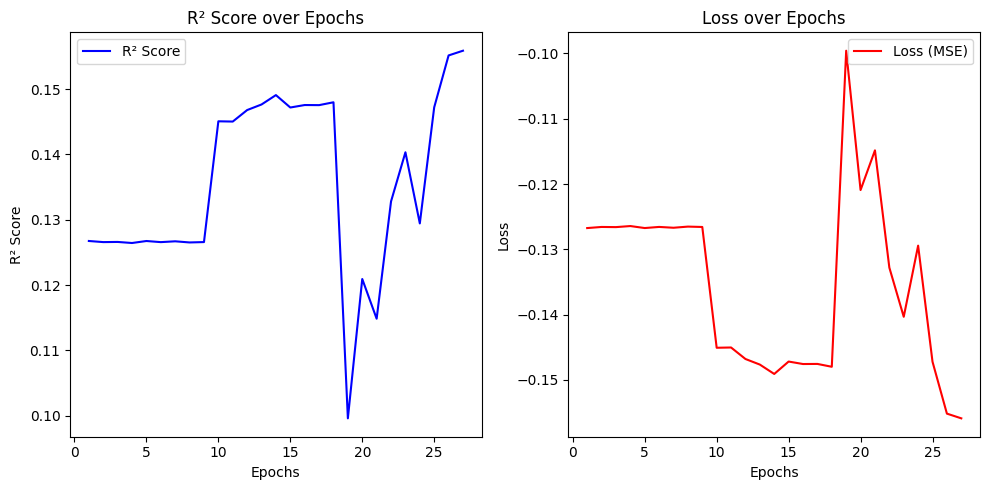

In [18]:

# Plotting R² score and loss
epochs = np.arange(1, len(grid_search.cv_results_['mean_test_score']) + 1)

plt.figure(figsize=(10, 5))

# Plot R² score
plt.subplot(1, 2, 1)
plt.plot(epochs, grid_search.cv_results_['mean_test_score'], label='R² Score', color='blue')
plt.xlabel('Epochs')
plt.ylabel('R² Score')
plt.title('R² Score over Epochs')
plt.legend()

# Plot Loss (MSE)
plt.subplot(1, 2, 2)
plt.plot(epochs, grid_search.cv_results_['mean_test_score'] * -1, label='Loss (MSE)', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()